# Fake News Detector
**Caitlin Petro** @ UNCC / ITCS-5156

## Imports

In [2]:
# Preprocessing
import os 
import warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# BERT
from pytorch_pretrained_bert import BertTokenizer
from keras_preprocessing.sequence import pad_sequences

# Data Loading

In [3]:
col_names = ['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker_Job_Title', 
                    'State_Info', 'Party_Affiliation', 'Barely_True_Count', 'False_Count', 
                    'Half_True_Count', 'Mostly_True_Count', 'Pants_On_Fire_Count', 'Context']

In [4]:
def load_news_data(n=col_names, s=r'\t', e='python'):
    
    pth = 'liar_dataset/'
    liar_data = [pth+'train.tsv', pth+'test.tsv', pth+'valid.tsv']
    
    for data in liar_data:
        if not os.path.exists(data):
            warnings.warn("Data not detected in your local path!")  
    
    trn = pd.read_csv(liar_data[0], sep=s, names=n, engine=e)
    tst = pd.read_csv(liar_data[1], sep=s, names=n, engine=e)
    vld = pd.read_csv(liar_data[2], sep=s, names=n, engine=e)
    
    print('Liar dataset has been loaded successfully')
    return trn, tst, vld

In [5]:
df_train, df_test, df_valid = load_news_data()

Liar dataset has been loaded successfully


# Data Preprocessing Methods

In [6]:
# Replace NaNs
def replace_nans(df):
    df = df.replace(np.nan, 'none')
    return df

In [7]:
# Binarze 'Label' column
def binarize_labels(df):
    true_labels = ['true', 'mostly-true']
    false_labels = ['half-true', 'barely-true', 'pants-fire']
    
    df['Label'] = df['Label'].replace(true_labels, 'true')
    df['Label'] = df['Label'].replace(false_labels, 'false')
    return df

In [8]:
# Encode 'Label' column
def encode_label(df, col='Label', cat_col='Label_Cat'):
    labelencoder = LabelEncoder()
    df[cat_col] = labelencoder.fit_transform(df[col])
    return df

In [9]:
# Drop columns
def drop_columns(df):
    cols_to_drop = ['ID', 'Label', 'Barely_True_Count', 'False_Count', 
                'Half_True_Count', 'Mostly_True_Count', 'Pants_On_Fire_Count']
    df = df.drop(labels=cols_to_drop, axis=1)
    return df

In [10]:
# Convert strings in columns to lower-case
def to_lowercase(df):
    cols = ['Statement', 'Subject', 'Speaker', 'Speaker_Job_Title', 'State_Info', 'Party_Affiliation', 'Context']
    for col in cols:
        df[col] = df[col].str.lower()
    return df

# Apply Data Preprocessing

In [11]:
def apply_preprocessing(df):
    df = (df.pipe(replace_nans)
            .pipe(binarize_labels)
            .pipe(encode_label)
            .pipe(drop_columns)
            .pipe(to_lowercase))
    return df

df_train = apply_preprocessing(df_train)
print("df_train successfully preprocessed")

df_test = apply_preprocessing(df_test)
print("df_test successfully preprocessed")

df_valid = apply_preprocessing(df_valid)
print("df_valid successfully preprocessed")

df_train successfully preprocessed
df_test successfully preprocessed
df_valid successfully preprocessed


# Label Distribution

Training set label distribution
Fake = 6620, True = 3649


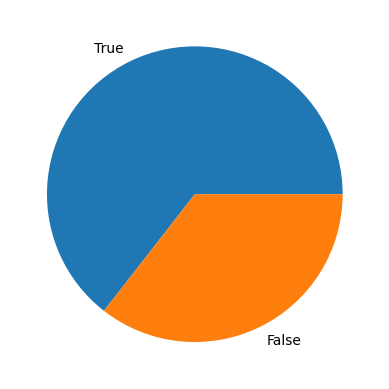

Testing set label distribution
Fake = 823, True = 460


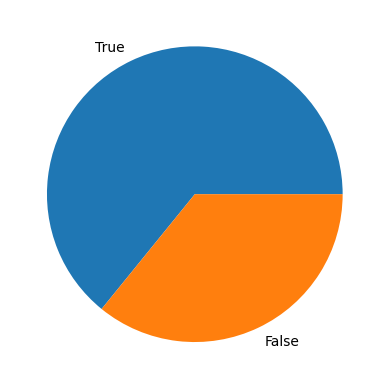

Validation set label distribution
Fake = 864, True = 420


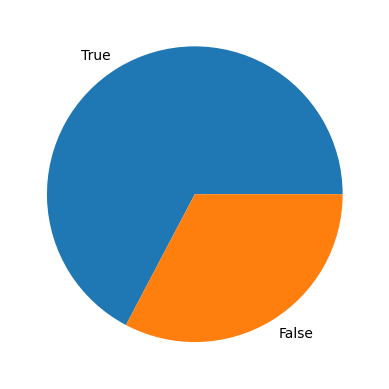

In [12]:
def distribute_labels(df):       
    df_label_cnts = df['Label_Cat'].value_counts()
    print('Fake = ' + str(df_label_cnts[0]) + ", True = " + str(df_label_cnts[1]))
    plt.pie(df_label_cnts, labels=['True', 'False'])
    plt.show()
    
print("Training set label distribution")
distribute_labels(df_train)

print("Testing set label distribution")
distribute_labels(df_test)

print("Validation set label distribution")
distribute_labels(df_valid)

In [13]:
df_train.head(5)

,Statement,Subject,Speaker,Speaker_Job_Title,State_Info,Party_Affiliation,Context,Label_Cat
0,says the annies list political group supports ...,abortion,dwayne-bohac,state representative,texas,republican,a mailer,0
1,when did the decline of coal start? it started...,"energy,history,job-accomplishments",scott-surovell,state delegate,virginia,democrat,a floor speech.,0
2,"hillary clinton agrees with john mccain ""by vo...",foreign-policy,barack-obama,president,illinois,democrat,denver,1
3,health care reform legislation is likely to ma...,health-care,blog-posting,none,none,none,a news release,0
4,the economic turnaround started at the end of ...,"economy,jobs",charlie-crist,none,florida,democrat,an interview on cnn,0


# Text Classification with Logistic Regression

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns

In [15]:
train_statements = df_train['Statement']
train_labels = df_train['Label_Cat']

test_statements = df_test['Statement']
test_labels = df_test['Label_Cat']

cv = CountVectorizer()
train_cv = cv.fit_transform(train_statements)
train_cv.shape

(10269, 12138)

In [16]:
lr = LogisticRegression()
lr.fit(train_cv, train_labels)

test_cv = cv.transform(test_statements)

predictions = lr.predict(test_cv)
predictions

C:\Users\welcm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 1, 0])

In [17]:
cf_matrix = metrics.confusion_matrix(test_labels,predictions)

<AxesSubplot:>

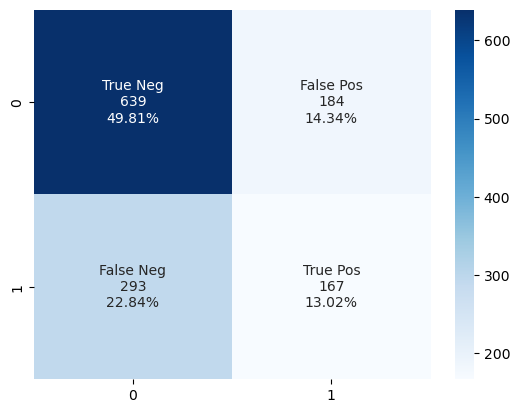

In [18]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')